<h1>This is the code for COM3013 Coursework</h1>
<h2>Mofe Awosanya, Ebose Odijie, Hishaam Khan</h2>

These are all the imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
import random

Check if machine is using CUDA GPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


We are using pytorch here to get the CIFAR10 dataset and set the classes.

In [3]:
import torch.multiprocessing as mp

# Set the sharing strategy
mp.set_sharing_strategy('file_system')

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

x_list = []
y_list = []

for inputs, labels in trainloader:
    x_list.append(inputs)
    y_list.append(labels)

x = torch.cat(x_list, dim=0)
y = torch.cat(y_list, dim=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's see some of the images

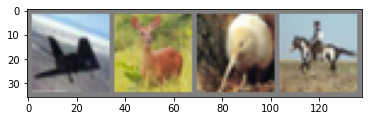

plane deer  bird  horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now to create the forward Neural Network

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 120)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
model = Model()
model = model.float()

print(model)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Now to define the Loss Function

In [6]:
loss_func = torch.nn.CrossEntropyLoss()
loss_values = []

Now to Define the Optimisation Function for the majority of the layers, for the final layer we will be using our own.

In [7]:
default_optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

This is the setup for the genetic algorithm

In [8]:
from deap import creator, base, tools, algorithms
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

pop_size = 4 #population size
num_of_bits = 30 #number of bits in a chromosome
iterations = 30 #number of generations
dspInterval = 5

cross_prob = 0.75 #crossover probability
mutate_prob = 0.95 #mutation probability
num_elitists = 5 #the number of elite individuals selected

maxnum = 2*num_of_bits

fc1shape = 256*4*4*120
fc2shape = 120*84
fc3shape = 84*10

chromosome_length = ((256*4*4)+1)*120+(120+1)*84+(84+1)*10

flip_prob = 1. / (chromosome_length * num_of_bits/30)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, num_of_bits*(chromosome_length))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def retrieve_weights():
    fc1list = model.fc1.weight.reshape(fc1shape).tolist()
    fc2list = model.fc2.weight.reshape(fc2shape).tolist()
    fc3list = model.fc3.weight.reshape(fc3shape).tolist()

    fc1bias = model.fc1.bias.reshape(120).tolist()
    fc2bias = model.fc2.bias.reshape(84).tolist()
    fc3bias = model.fc3.bias.reshape(10).tolist()

    weights = fc1list + fc2list + fc3list + fc1bias + fc2bias + fc3bias

    return weights

def real_to_chromosome(weight):
    weight = weight/20
    if weight < -1:
        weight = -1
    if weight > 1:
        weight = 1
    integerPart = int(maxnum * (weight + 1 ) / 2)
    if (integerPart == maxnum):
        integerPart -= 1
    chromosome = [int(d) for d in str(bin(integerPart))[2:]]
    while (len(chromosome) < num_of_bits):
        chromosome.insert(0, 0)
    indasstring=''.join(map(str, chromosome))
    chromosome=bin_to_gray(indasstring)
    output=[]
    for digit in chromosome:
        output.append(int(digit))

    return output

def chromosome_to_real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2)
    numinrange=-1.0+2.0*numasint/maxnum
    return numinrange*20

def separatevariables(v):
    sep = []
    for i in range (0,num_of_bits*(chromosome_length),num_of_bits):
        sep.append(chromosome_to_real(v[i:i+num_of_bits]))
    return sep

Now to train our model with the default optimiser for 30 epochs.

In [9]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        default_optimizer.zero_grad()
        loss.backward()
        default_optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished using SGD Optimization')


[1,  2000] loss: 2.226
[1,  4000] loss: 1.857
[1,  6000] loss: 1.607
[1,  8000] loss: 1.457
[1, 10000] loss: 1.358
[1, 12000] loss: 1.281
[2,  2000] loss: 1.148
[2,  4000] loss: 1.089
[2,  6000] loss: 1.026
[2,  8000] loss: 1.015
[2, 10000] loss: 0.954
[2, 12000] loss: 0.925
Finished using SGD Optimization


Fitness Calculation Function

In [10]:
def calc_fitness(individual):
    weights=separatevariables(individual)
    weights = np.asarray(weights)
    
    
    print("Original shapes:", weights[:fc1shape].shape, weights[fc1shape:fc1shape + fc2shape].shape, weights[fc1shape + fc2shape: fc1shape + fc2shape + fc3shape].shape)

    model.fc1.weight = torch.nn.Parameter(torch.from_numpy(weights[:(fc1shape)].reshape(256*4*4, 120).T).float())
    model.fc2.weight = torch.nn.Parameter(torch.from_numpy(weights[fc1shape:fc1shape+fc2shape].reshape(84, 120)).float())
    model.fc3.weight = torch.nn.Parameter(torch.from_numpy(weights[fc1shape+fc2shape: fc1shape+fc2shape+fc3shape].reshape(84, 10).T).float())

    model.fc1.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape: fc1shape + fc2shape + fc3shape + 120]).float())
    model.fc2.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape + 120: fc1shape + fc2shape + fc3shape + 120 + 84]).float())
    model.fc3.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape + 120 + 84: fc1shape + fc2shape + fc3shape + 120 + 84 + 10]).float())

    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        finputs = inputs.float()
        outputs = model(finputs)
        loss = loss_func(outputs, labels)
    return loss.item()

toolbox.register("evaluate", calc_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=flip_prob)
toolbox.register("select", tools.selTournament, fit_attr="fitness")


Retrieve the weights from the training

In [11]:
popa = toolbox.population(n=pop_size)
pop=[]
for individual in popa:
    sep = separatevariables(individual)
    print(sep)
    weightlist=[]
    for weight in sep:
        weightlist+=real_to_chromosome(weight)
    pop.append(creator.Individual(weightlist))

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = (fit,)

print(" Evaluated %i individuals" % len(pop))

fits = [ind.fitness.values[0] for ind in pop]

g = 0

while g < iterations:
    g = g + 1
    print("-- Generation %i -- " % g)

    offspring = tools.selBest(pop, num_elitists)
    offspring += toolbox.select(pop, len(pop)-num_elitists, 2)
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[4::2], offspring[5::2]):
        if random.random() < cross_prob:
            toolbox.mate(child1, child2)

            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring[4::]:
        if random.random() < mutate_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    for individual in offspring:
        weights = retrieve_weights()
        individual.clear()
        newInd=[]
        for index in range(len(weights)):
            chromosome = real_to_chromosome(weights[index])
            newInd += chromosome
        newInd = creator.Individual(newInd)
        offspring.remove(individual)
        offspring.append(newInd)
    
    pop[:] = offspring
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = (fit,)

    fits = [ind.fitness.values[0] for ind in pop]
    loss_values.append(min(fits))

    if g%dspInterval == 0:
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        print(" Min %s" % min(fits))
        print(" Max %s" % max(fits))
        print(" Avg %s" % mean)
        print(" Std %s" % std)

print("-- Completed Evolution --")

best_individual = tools.selBest(pop, 1)[0]
print("Fitness %s" % (calc_fitness(best_individual)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
 Evaluated 4 individuals
-- Generation 1 -- 
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
-- Generation 2 -- 
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
-- Generation 3 -- 
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
-- Generation 4 -- 
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
-- Generation 5 -- 
Original shapes

Save the Model

In [12]:
PATH = './cifar_model.pth'
torch.save(model.state_dict(), PATH)

lets look at some of the testing images

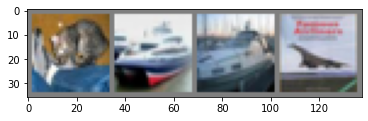

GroundTruth:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4))) 

Now to evaluate the model using the testing batch

In [14]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Model Accuracy on Testing Images: {100 * correct // total} %')

Model Accuracy on Testing Images: 10 %
